# Forecasting 101

El propósito de esta notebook es mostrar ejemplos prácticos del proceso de Forecasting en sus cuatro etapas

* Entendimiento de la serie
* Armado de benchmarks
* Experimentación y predicción
* Medición

Usaremos datos reales de la estación Alberdi de peajes de la Ciudad de Buenos Aires para ilustrar cada etapa del proceso

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
train_csv_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTbVTW5BP1isLPOMrIBwcxAoNwJcx0kXxf-av3whWnlzM3yZozeuMPsMsMrmns86P_soyphbjGfWklD/pub?gid=189010472&single=true&output=csv'

df = pd.read_csv(train_csv_url)
df['fecha'] = pd.to_datetime(df['fecha'], format = '%d/%m/%Y')
df.head()

,estacion,fecha,cantidad_pasos
0,alberdi,2016-01-01,5446.0
1,alberdi,2016-01-02,6927.0
2,alberdi,2016-01-03,6630.0
3,alberdi,2016-01-04,9835.0
4,alberdi,2016-01-05,9091.0


In [ ]:
# Armamos una funcion inicial para plotear resultados
def plot_results(df: pd.DataFrame,
                 start_date: str = '2019-04-01',
                 end_date: str = '2019-07-31',
                 forecast_col: list = None,
                 model_name: str = None) -> None:
    # Filtramos por fecha
    df_filt = df[(df['fecha'] >= start_date) & (df['fecha'] <= end_date)]

    # Creamos el grafico
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(df_filt['fecha'], df_filt['cantidad_pasos'], label='Historia')

    # Si tenemos un forecast, lo graficamos
    if forecast_col:
        for col in forecast_col:
            ax.plot(df_filt['fecha'], df_filt[col], label=f'Forecast - {col}')

    if model_name:
        ax.set_title(f'Historia y forecast - modelo {model_name}')
    else:
        ax.set_title(f'Serie histórica')

    ax.legend()
    ax.tick_params(labelrotation=90)
    plt.show();

## Entendimiento de la serie

Comenzamos haciendo un gráfico que visualice la serie completa

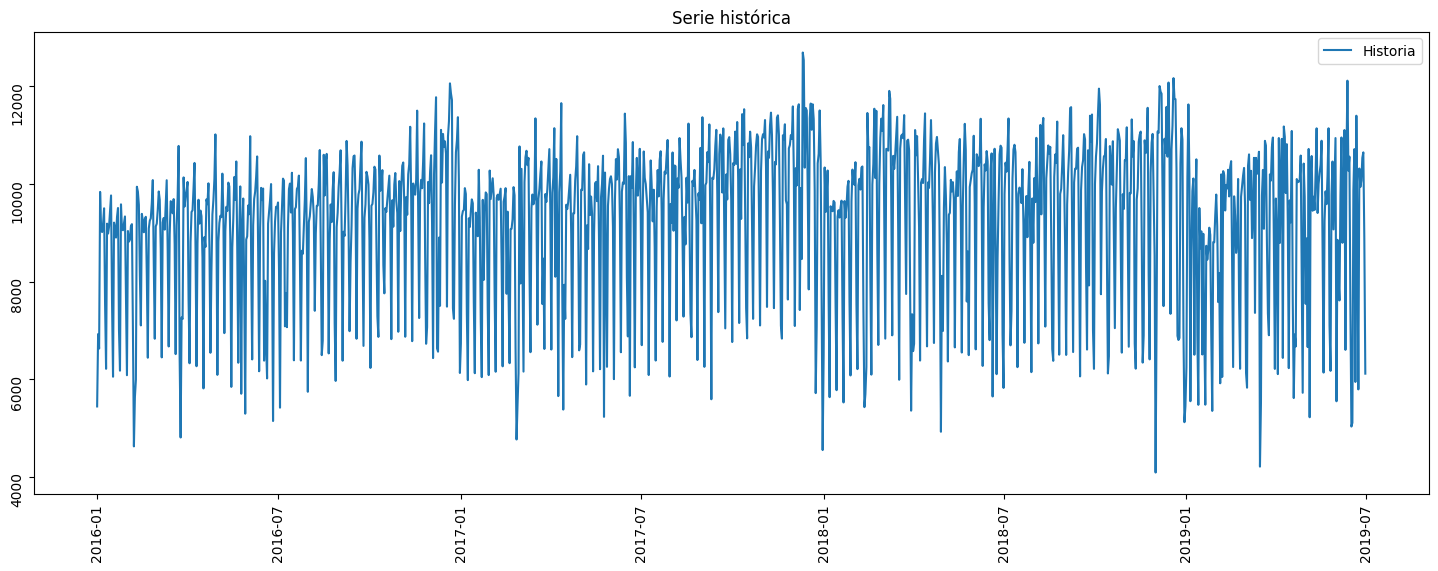

In [ ]:
plot_results(df, start_date='2016-01-01')

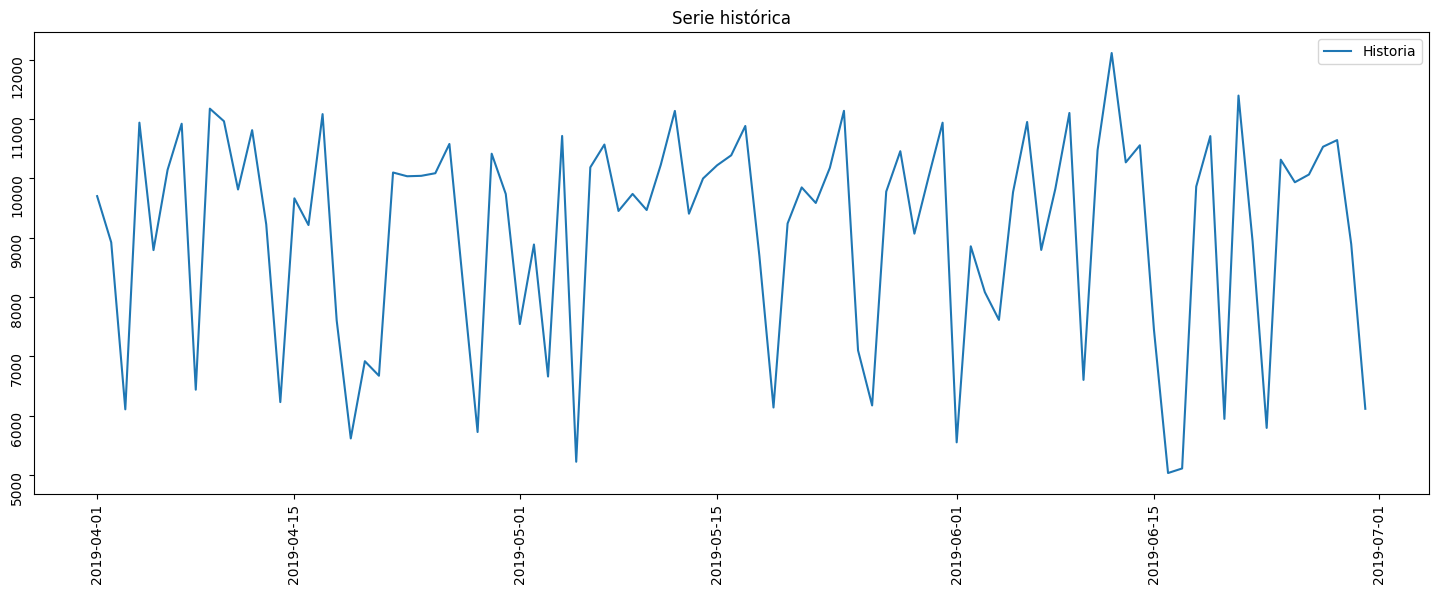

In [ ]:
plot_results(df)

## Análisis de tendencia y estacionalidad


#### Análisis simple


##### Tendencia
Comenzamos haciendo promedios por año-mes para evaluar la existencia de tendencia

In [ ]:
# Creamos una columna por year-month
df['Year'] = df['fecha'].dt.strftime('%Y')
df.head()

,estacion,fecha,cantidad_pasos,Year
0,alberdi,2016-01-01,5446.0,2016
1,alberdi,2016-01-02,6927.0,2016
2,alberdi,2016-01-03,6630.0,2016
3,alberdi,2016-01-04,9835.0,2016
4,alberdi,2016-01-05,9091.0,2016


In [ ]:
df_year = df.groupby('Year')['cantidad_pasos'].mean().reset_index().sort_values(by='Year')

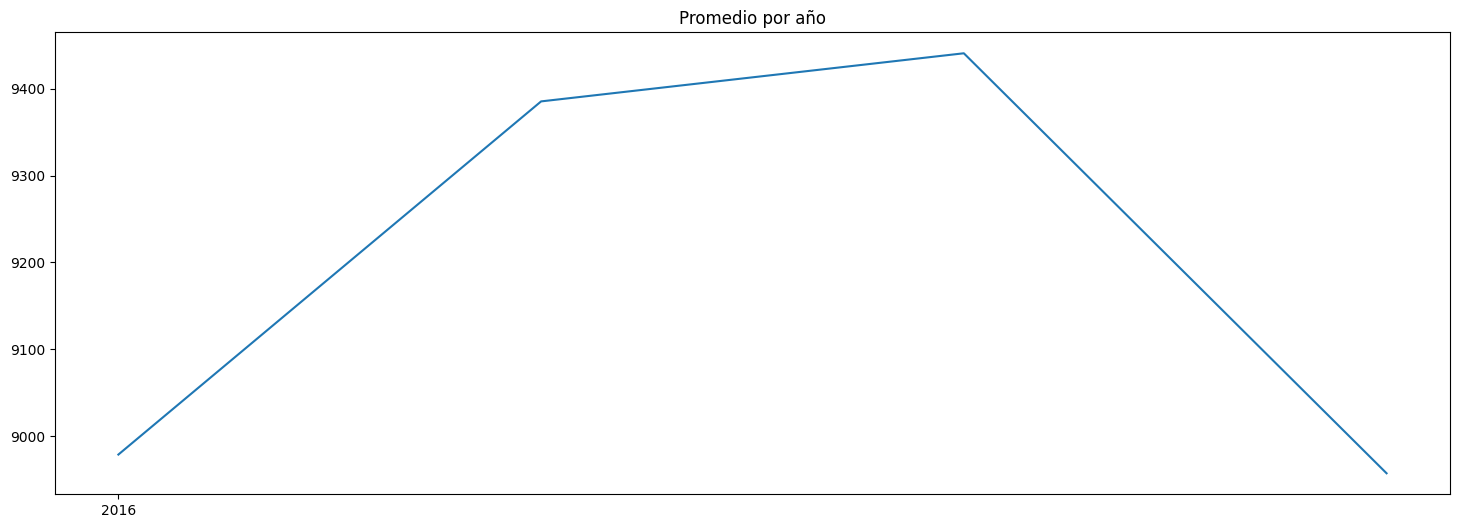

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df_year['Year'], df_year['cantidad_pasos'])
ax.set_title(f'Promedio por año')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.show();

In [ ]:
# Creamos una columna por year-month
df['Year-Month'] = df['fecha'].dt.strftime('%Y-%m')
df.head()

,estacion,fecha,cantidad_pasos,Year,Year-Month
0,alberdi,2016-01-01,5446.0,2016,2016-01
1,alberdi,2016-01-02,6927.0,2016,2016-01
2,alberdi,2016-01-03,6630.0,2016,2016-01
3,alberdi,2016-01-04,9835.0,2016,2016-01
4,alberdi,2016-01-05,9091.0,2016,2016-01


In [ ]:
# Obtenemos el promedio por year-month
df_year_month = df.groupby('Year-Month')['cantidad_pasos'].mean().reset_index().sort_values(by='Year-Month')
df_year_month.head()

,Year-Month,cantidad_pasos
0,2016-01,8348.677419
1,2016-02,8459.896552
2,2016-03,8810.193548
3,2016-04,8914.500000
4,2016-05,8698.903226


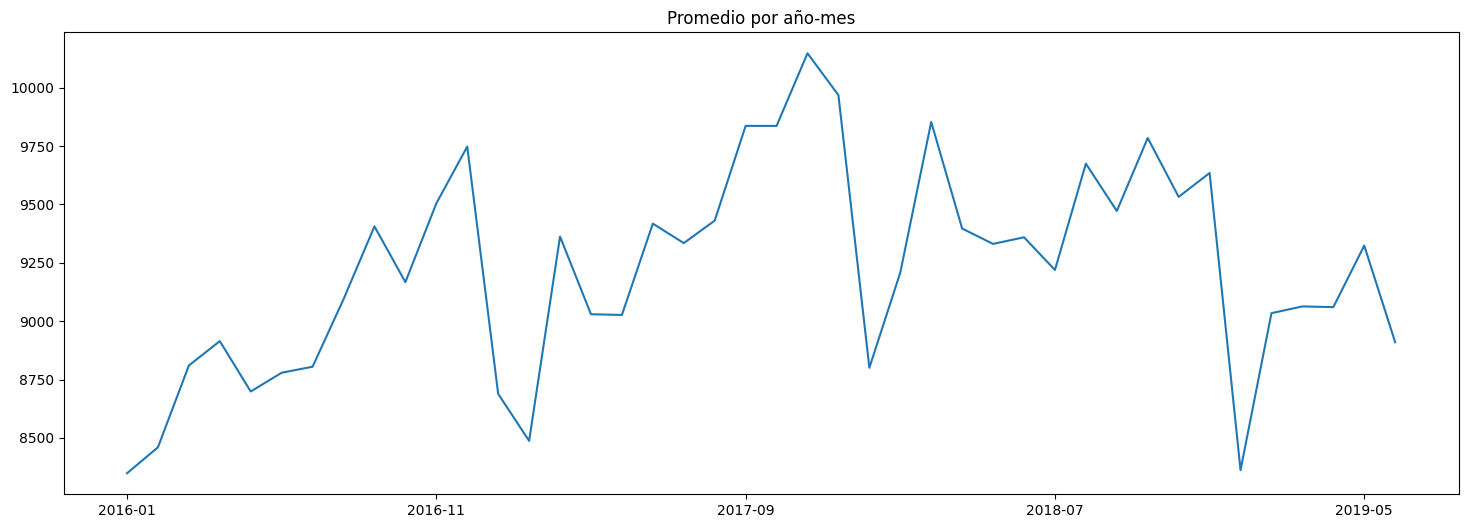

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df_year_month['Year-Month'], df_year_month['cantidad_pasos'])
ax.set_title(f'Promedio por año-mes')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.show();

Con esto podemos ver que por más que no existe una gran tendencia, lo que sí podemos observar es una tendencia en principio mensual, con una caída durante el verano

##### Estacionalidad

In [ ]:
df['Month'] = df['fecha'].dt.month
df.head()

,estacion,fecha,cantidad_pasos,Year,Year-Month,Month
0,alberdi,2016-01-01,5446.0,2016,2016-01,1
1,alberdi,2016-01-02,6927.0,2016,2016-01,1
2,alberdi,2016-01-03,6630.0,2016,2016-01,1
3,alberdi,2016-01-04,9835.0,2016,2016-01,1
4,alberdi,2016-01-05,9091.0,2016,2016-01,1


In [ ]:
# Obtenemos el promedio por year-month
df_month = df.groupby(['Month'])['cantidad_pasos'].mean().reset_index().sort_values(
    by='Month').rename(columns={'cantidad_pasos': 'avg_by_month'})
df_month.head()

,Month,avg_by_month
0,1,8550.056452
1,2,8794.469027
2,3,9272.201613
3,4,9100.216667
4,5,9095.040323


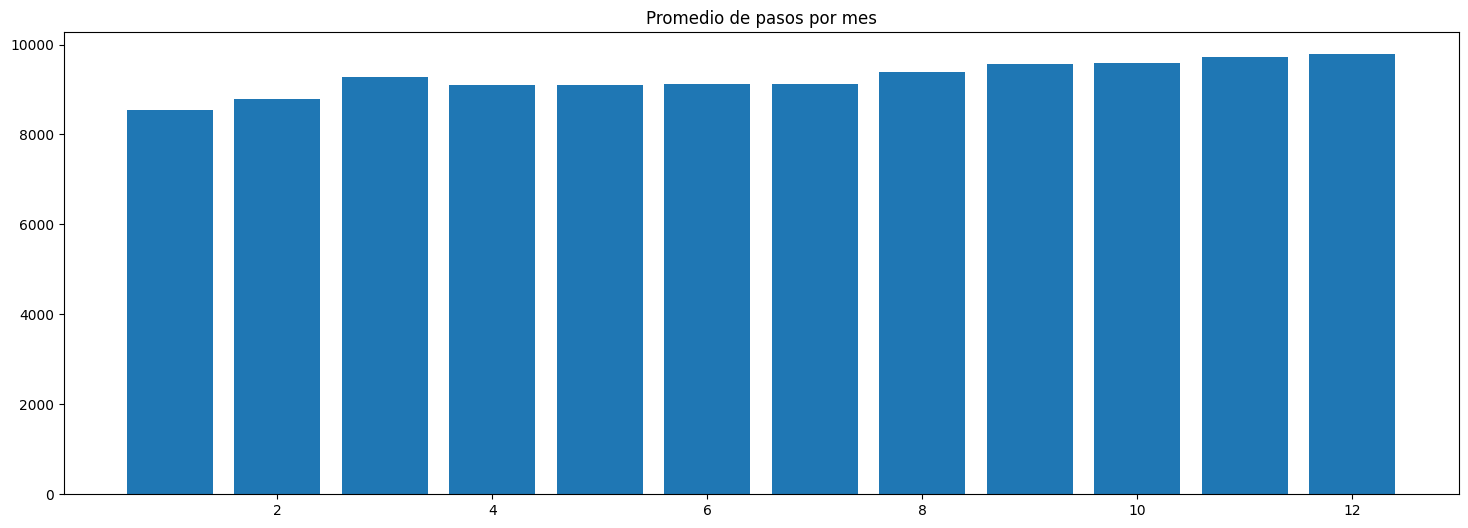

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(df_month['Month'], df_month['avg_by_month'])
ax.set_title(f'Promedio de pasos por mes')
plt.show();

In [ ]:
df['Weekday'] = df['fecha'].dt.weekday
df['Weekday_Name'] = df['fecha'].dt.day_name()
df.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name
0,alberdi,2016-01-01,5446.0,2016-01,4,Friday
1,alberdi,2016-01-02,6927.0,2016-01,5,Saturday
2,alberdi,2016-01-03,6630.0,2016-01,6,Sunday
3,alberdi,2016-01-04,9835.0,2016-01,0,Monday
4,alberdi,2016-01-05,9091.0,2016-01,1,Tuesday


In [ ]:
# Obtenemos el promedio por year-month
df_weekday = df.groupby(['Weekday', 'Weekday_Name'])['cantidad_pasos'].mean().reset_index().sort_values(
    by='Weekday').rename(columns={'cantidad_pasos': 'avg_by_weekday'})
df_weekday.head()

,Weekday,Weekday_Name,avg_by_weekday
0,0,Monday,9240.131868
1,1,Tuesday,9777.725275
2,2,Wednesday,10049.565934
3,3,Thursday,10100.148352
4,4,Friday,10208.830601


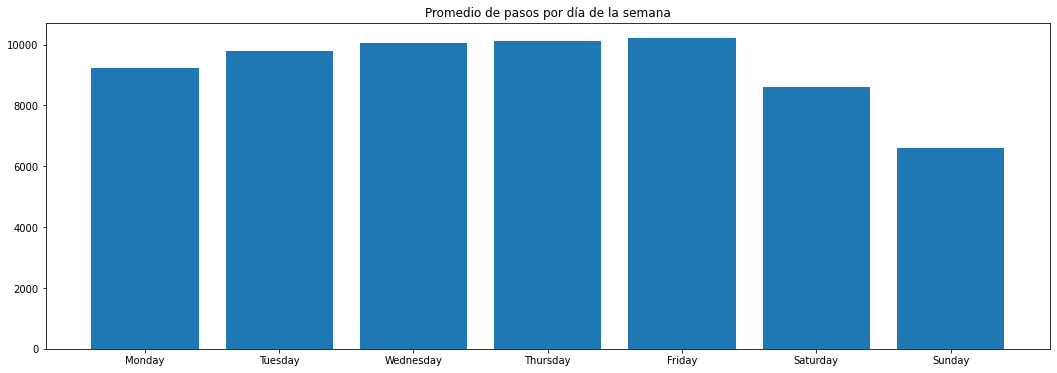

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(df_weekday['Weekday_Name'], df_weekday['avg_by_weekday'])
ax.set_title(f'Promedio de pasos por día de la semana')
plt.show();

En este caso, es claro ver la caída durante los fines de semana, en especial durante los domingos. En este caso, podemos señalar la existencia de estacionalidad

#### Análisis estadístico



##### Decomposición de la serie de tiempo

In [ ]:
df_no_nan = df[df['fecha'] < '2019-07-01'].set_index('fecha')
ts_dicomposition = seasonal_decompose(df_no_nan['cantidad_pasos'], period=364);

In [ ]:
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid

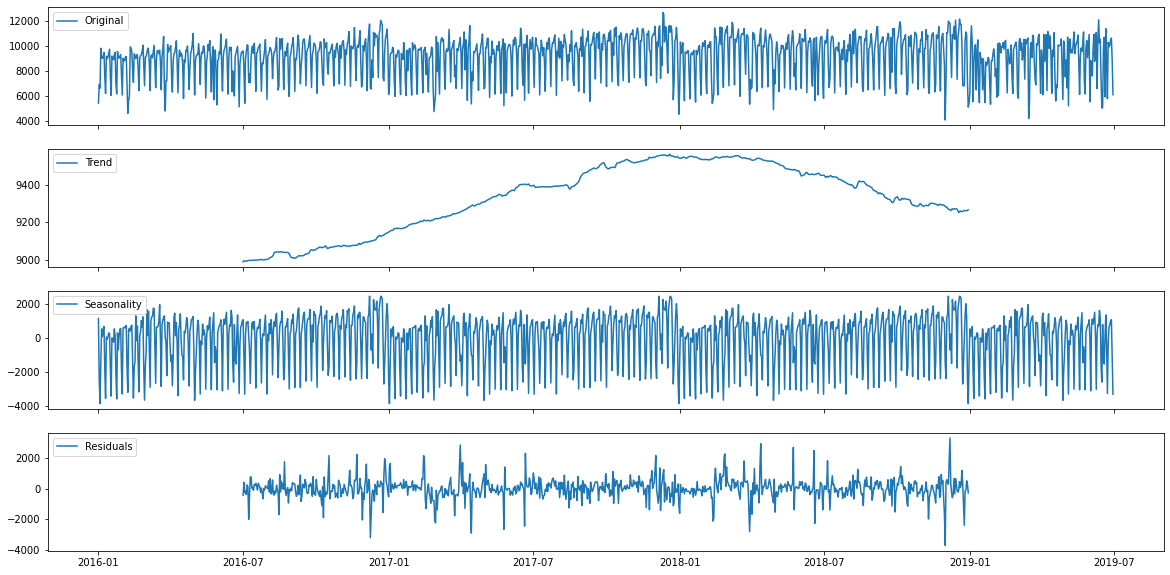

In [ ]:
# Codigo disponible aca: https://www.section.io/engineering-education/time-series-decomposition-in-python/

# Ploteo la serie y sus complenentes
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)

# Serie original
axes[0].plot(df['fecha'], df['cantidad_pasos'], label='Original')
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left')
plt.show();

##### Tendencia
Empezamos calculando el ROT

In [ ]:
df['lag_1'] = df['cantidad_pasos'].shift(1)
df['diff_1'] = df['cantidad_pasos'] - df['lag_1']
df.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1
0,alberdi,2016-01-01,5446.0,2016-01,4,Friday,NaN,NaN
1,alberdi,2016-01-02,6927.0,2016-01,5,Saturday,5446.0,1481.0
2,alberdi,2016-01-03,6630.0,2016-01,6,Sunday,6927.0,-297.0
3,alberdi,2016-01-04,9835.0,2016-01,0,Monday,6630.0,3205.0
4,alberdi,2016-01-05,9091.0,2016-01,1,Tuesday,9835.0,-744.0


In [ ]:
ROT = np.mean(df['diff_1'])/np.mean(df['cantidad_pasos'])
if ROT < 0.001:
    print(f'ROT: {ROT}. La serie NO tiene tendencia')
else:
    print(f'ROT: {ROT}. La serie SÍ tiene tendencia')

ROT: 5.701030960278677e-05. La serie NO tiene tendencia


##### Estacionalidad
Empezamos calculando el coeficiente de autocorrelación. Dada la estacionalidad semanal, tomamos 364 dias como un año en vez de 365, para que quede emparejado el tema de semanas

In [ ]:
df_2017 = df[(df['fecha'] >= '2017-01-01') & (df['fecha'] <= '2017-12-30')]
df_2017.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1
366,alberdi,2017-01-01,6735.0,2017-01,6,Sunday,6131.0,604.0
367,alberdi,2017-01-02,9331.0,2017-01,0,Monday,6735.0,2596.0
368,alberdi,2017-01-03,9442.0,2017-01,1,Tuesday,9331.0,111.0
369,alberdi,2017-01-04,9467.0,2017-01,2,Wednesday,9442.0,25.0
370,alberdi,2017-01-05,9912.0,2017-01,3,Thursday,9467.0,445.0


In [ ]:
df_2018 = df[(df['fecha'] >= '2017-12-31') & (df['fecha'] <= '2018-12-29')]
df_2018.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1
730,alberdi,2017-12-31,4554.0,2017-12,6,Sunday,7368.0,-2814.0
731,alberdi,2018-01-01,6494.0,2018-01,0,Monday,4554.0,1940.0
732,alberdi,2018-01-02,10335.0,2018-01,1,Tuesday,6494.0,3841.0
733,alberdi,2018-01-03,9425.0,2018-01,2,Wednesday,10335.0,-910.0
734,alberdi,2018-01-04,9770.0,2018-01,3,Thursday,9425.0,345.0


In [ ]:
corr = pearsonr(df_2017['cantidad_pasos'], df_2018['cantidad_pasos'])[0]
if corr <= 0.6:
    print(f'Autocorrelacion: {corr}. No hay estacionalidad')
else:
    print(f'Autocorrelacion: {corr}. Sí hay estacionalidad')

Autocorrelacion: 0.696340299441798. Sí hay estacionalidad


In [ ]:
# Ahora hacemos lo mismo con un analisis de regresion.
# Primero para los meses
df['month'] = df['fecha'].dt.month_name()
df = pd.concat(
                [
                    df,
                    pd.get_dummies(df['month'], prefix='month', prefix_sep='-', drop_first=True)
                ], axis=1)
cols = pd.get_dummies(df['month'], prefix='month', prefix_sep='-', drop_first=True).columns

In [ ]:
df_no_nan = df[df['fecha'] < '2019-07-01']
Y = df_no_nan['cantidad_pasos']
X = df_no_nan[cols]
X = sm.add_constant(X)
ols = sm.OLS(Y, X)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         cantidad_pasos   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     5.788
Date:                Mon, 14 Nov 2022   Prob (F-statistic):           3.39e-09
Time:                        23:02:25   Log-Likelihood:                -11225.
No. Observations:                1277   AIC:                         2.247e+04
Df Residuals:                    1265   BIC:                         2.254e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9100.2167    145.747     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


En este caso se puede apreciar que el test estadístico muestra la existencia de estacionalidad mensual

In [ ]:
# Ahora hacemos lo mismo con un analisis de regresion.
# Primero para los meses
df = pd.concat(
                [
                    df,
                    pd.get_dummies(df['Weekday_Name'], prefix='Weekday_Name', prefix_sep='-', drop_first=True)
                ], axis=1)
cols = pd.get_dummies(df['Weekday_Name'], prefix='Weekday_Name', prefix_sep='-', drop_first=True).columns

In [ ]:
df_no_nan = df[df['fecha'] < '2019-07-01']
Y = df_no_nan['cantidad_pasos']
X = df_no_nan[cols]
X = sm.add_constant(X)
ols = sm.OLS(Y, X)
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         cantidad_pasos   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     245.5
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          2.41e-208
Time:                        23:04:02   Log-Likelihood:                -10764.
No. Observations:                1277   AIC:                         2.154e+04
Df Residuals:                    1270   BIC:                         2.158e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.02

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Acá podemos ver dos cosas: la clara de existencia de estacionalidad semanal, y además, el aumento del R2 al evaluar esta estacionalidad

## Análisis exploratorio - visualización y relación con otras variables

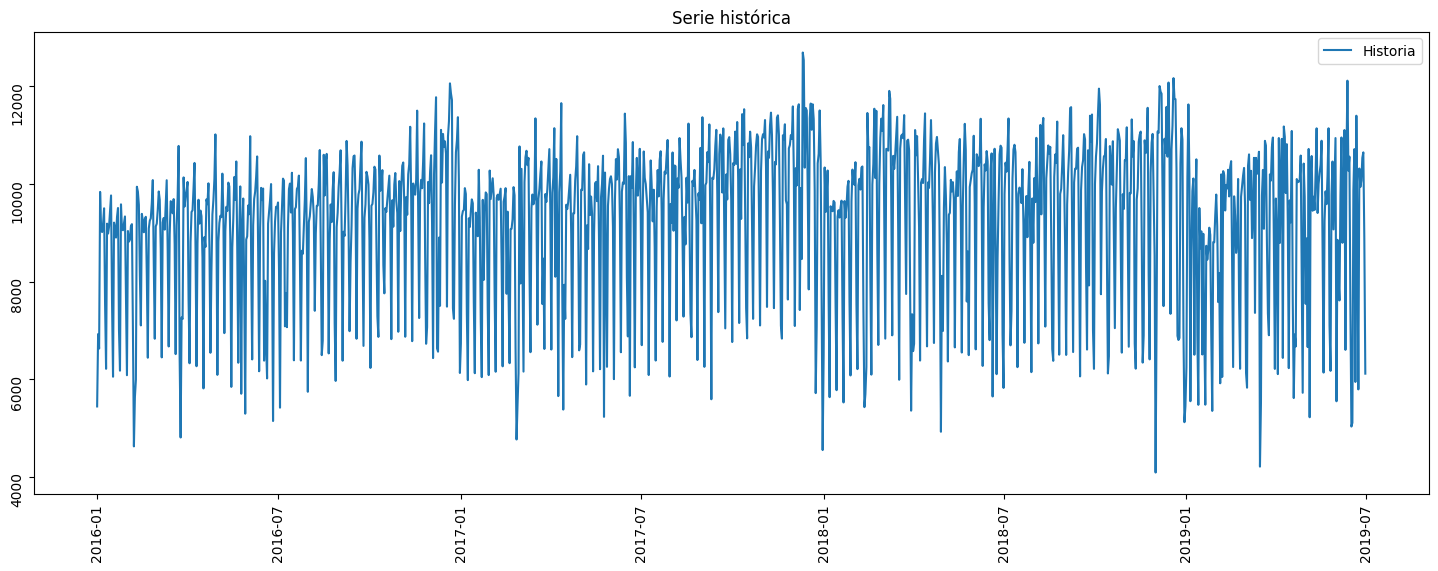

In [ ]:
plot_results(df, start_date='2016-01-01')

¿Qué puede estar pasando acá? Hay algunos valles demasiado importantes. Qué potencial explicación le podemos encontrar a esos?

In [ ]:
url_feriados = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTINTbyXCZut4r4k72fRJtKsSG-nI9WlegF1eLtZqtp_SVIcdbzhe_pZb67JuKoOukBGl2x3ruojs6W/pub?gid=148040929&single=true&output=csv'
df_holidays = pd.read_csv(url_feriados)
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'])

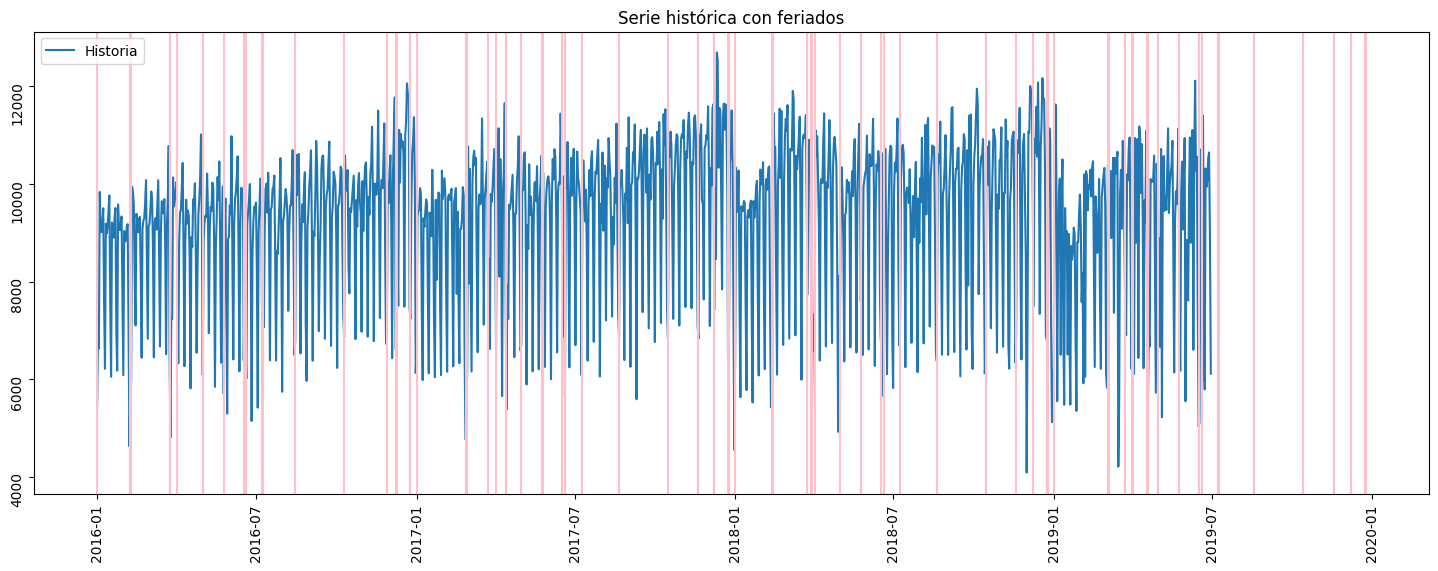

In [ ]:
# Creamos el grafico
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['fecha'], df['cantidad_pasos'], label='Historia')

for index, row in df_holidays.iterrows():
  plt.axvline(x = row['ds'], color = 'pink')

ax.set_title(f'Serie histórica con feriados')

ax.legend()
ax.tick_params(labelrotation=90)
plt.show();



## Guardamos el dataset preprocesado

In [ ]:
df.head()

,estacion,fecha,cantidad_pasos,Year-Month,Weekday,Weekday_Name,lag_1,diff_1,month,month-August,...,month-May,month-November,month-October,month-September,Weekday_Name-Monday,Weekday_Name-Saturday,Weekday_Name-Sunday,Weekday_Name-Thursday,Weekday_Name-Tuesday,Weekday_Name-Wednesday
0,alberdi,2016-01-01,5446.0,2016-01,4,Friday,NaN,NaN,January,0,...,0,0,0,0,0,0,0,0,0,0
1,alberdi,2016-01-02,6927.0,2016-01,5,Saturday,5446.0,1481.0,January,0,...,0,0,0,0,0,1,0,0,0,0
2,alberdi,2016-01-03,6630.0,2016-01,6,Sunday,6927.0,-297.0,January,0,...,0,0,0,0,0,0,1,0,0,0
3,alberdi,2016-01-04,9835.0,2016-01,0,Monday,6630.0,3205.0,January,0,...,0,0,0,0,1,0,0,0,0,0
4,alberdi,2016-01-05,9091.0,2016-01,1,Tuesday,9835.0,-744.0,January,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df.to_csv('peajes_alberdi_training_preproc.csv', index = False)